# **EDA for Stock1**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import random
import warnings
from typing import Tuple, List, Dict
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [4]:
stock1 = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_1.csv")
stock1.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100,1
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100,1
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125,1
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36,1
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25,1


In [5]:
if stock1["stock_id"].nunique() == 1:
    del stock1["stock_id"]
    stock1['time_id'] = pd.factorize(stock1['time_id'])[0] + 1
stock1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507532 entries, 0 to 1507531
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   time_id            1507532 non-null  int64  
 1   seconds_in_bucket  1507532 non-null  int64  
 2   bid_price1         1507532 non-null  float64
 3   ask_price1         1507532 non-null  float64
 4   bid_price2         1507532 non-null  float64
 5   ask_price2         1507532 non-null  float64
 6   bid_size1          1507532 non-null  int64  
 7   ask_size1          1507532 non-null  int64  
 8   bid_size2          1507532 non-null  int64  
 9   ask_size2          1507532 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 115.0 MB


## **TimeIDs and Buckets**

In [90]:
len(stock1["time_id"].unique())

3830

In [91]:
seconds_per_time_id = stock1.groupby("time_id")["seconds_in_bucket"].nunique()
print("Number of Seconds with Data per Time_ID:")
print(seconds_per_time_id)

Number of Seconds with Data per Time_ID:
time_id
1       575
2       370
3       353
4       171
5       227
       ... 
3826    307
3827    494
3828    313
3829    434
3830    305
Name: seconds_in_bucket, Length: 3830, dtype: int64


In [92]:
expected_seconds = 600
missing_seconds = expected_seconds - seconds_per_time_id
high_missing_threshold = 0.7 * expected_seconds 
high_missing_time_ids = missing_seconds[missing_seconds > high_missing_threshold]

print("Time IDs with 70% or more missing seconds:")
print(high_missing_time_ids.sort_values(ascending=False))

Time IDs with 70% or more missing seconds:
time_id
3312    468
1094    466
1687    465
3578    462
2965    461
2556    455
1843    454
784     451
821     450
278     446
356     446
2504    442
3530    441
1035    439
253     438
2954    437
433     436
1465    436
1629    436
3143    435
2849    434
3064    433
3346    433
3605    432
2761    431
1914    431
346     431
192     431
4       429
104     429
84      428
1836    427
2511    427
2374    427
1202    426
2429    426
2282    426
525     426
2933    426
651     425
3174    425
3558    425
2394    425
910     424
1669    424
1332    423
2357    423
965     422
2223    421
2939    421
2631    421
1717    421
Name: seconds_in_bucket, dtype: int64


In [93]:
high_missing_time_ids = missing_seconds[missing_seconds > high_missing_threshold].index
filtered_stock1 = stock1[~stock1["time_id"].isin(high_missing_time_ids)]
filtered_stock1.shape

(1498949, 10)

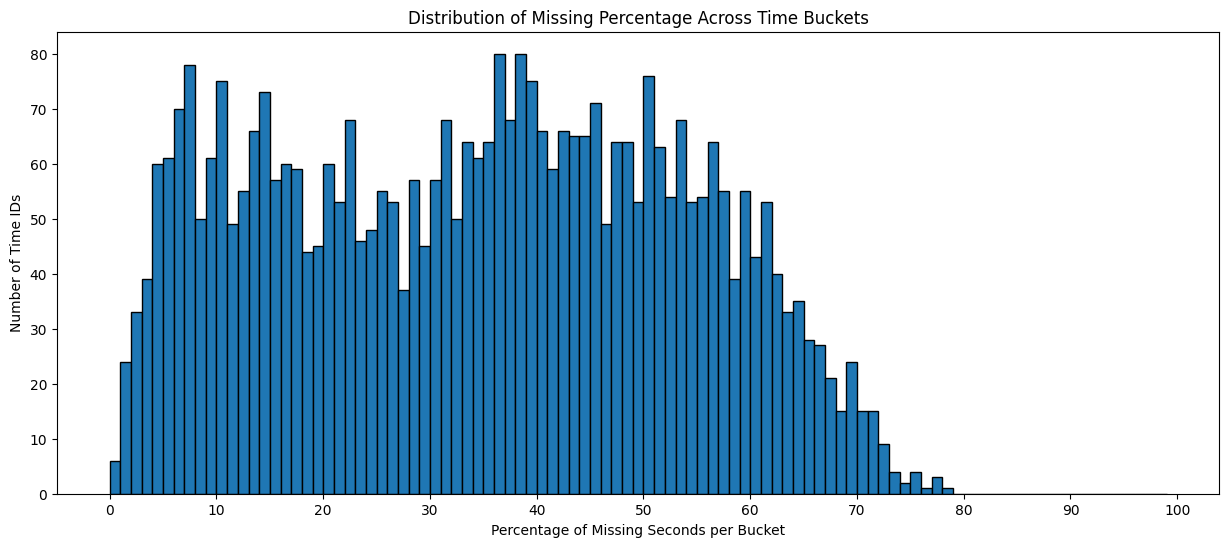

In [94]:
missing_percentage = (missing_seconds / expected_seconds) * 100
plt.figure(figsize=(15, 6))
bins = np.arange(0, 100, 1)
plt.hist(missing_percentage, bins=bins, edgecolor='black')
plt.xlabel("Percentage of Missing Seconds per Bucket")
plt.ylabel("Number of Time IDs")
plt.title("Distribution of Missing Percentage Across Time Buckets")
plt.xticks(np.arange(0, 105, 10))
plt.show()

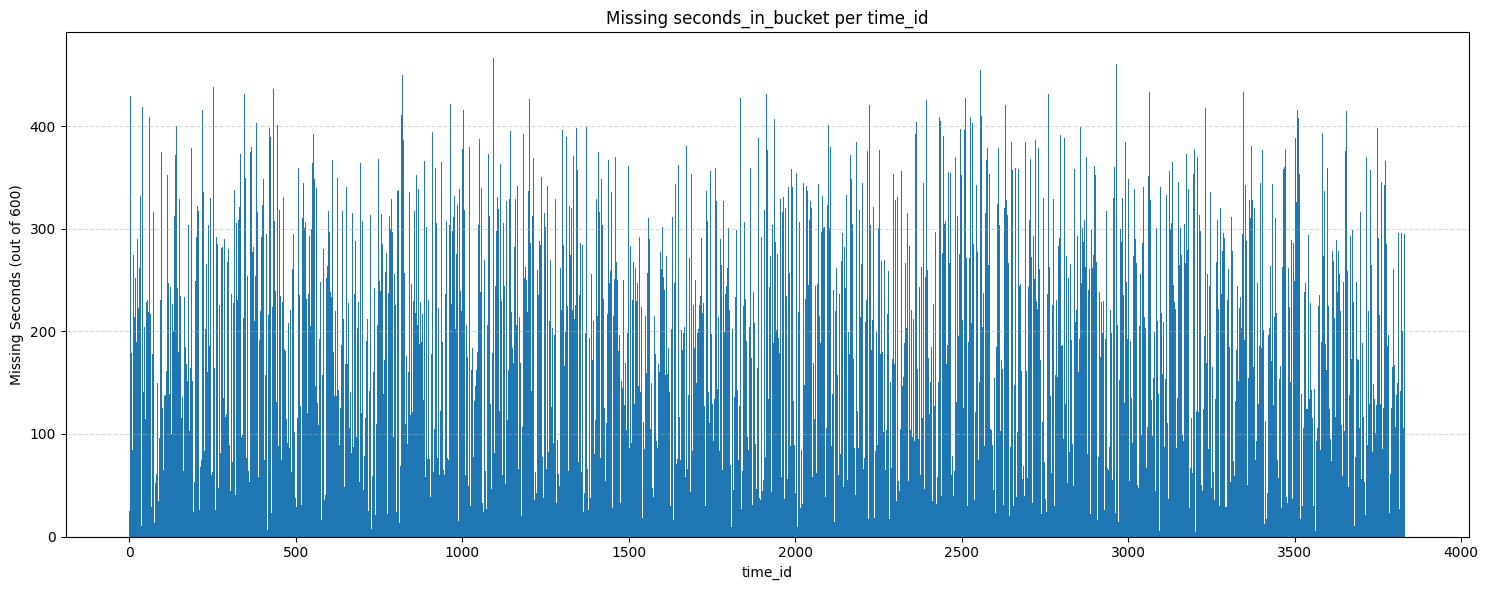

In [95]:
expected_seconds = set(range(600)) 
missing_counts = (
    stock1.groupby("time_id")["seconds_in_bucket"]
    .apply(lambda x: 600 - len(set(x)))
    .reset_index(name="missing_seconds")
)

plt.figure(figsize=(15, 6))
plt.bar(missing_counts["time_id"], missing_counts["missing_seconds"], width=1.0)
plt.xlabel("time_id")
plt.ylabel("Missing Seconds (out of 600)")
plt.title("Missing seconds_in_bucket per time_id")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

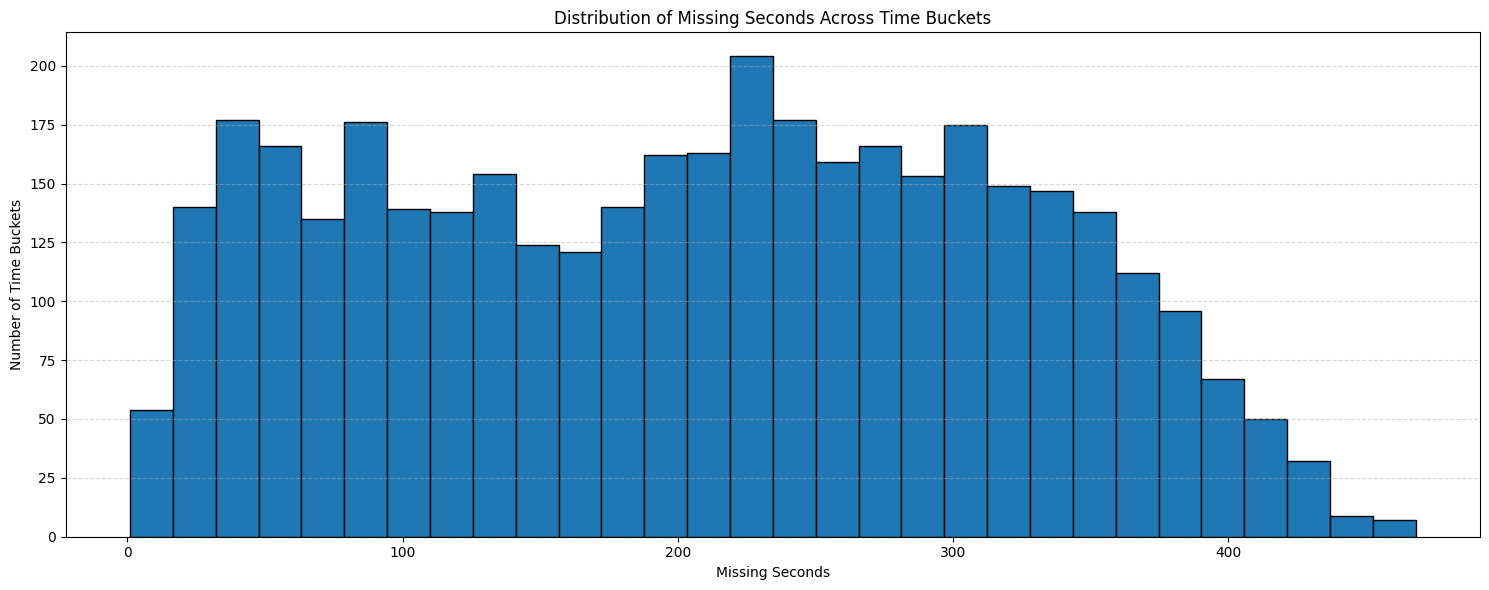

In [96]:
plt.figure(figsize=(15, 6))
plt.hist(missing_counts["missing_seconds"], bins=30, edgecolor='black')
plt.xlabel("Missing Seconds")
plt.ylabel("Number of Time Buckets")
plt.title("Distribution of Missing Seconds Across Time Buckets")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **Patterns in Missing Data**

In [97]:
df_copy = stock1.copy()

all_seconds = np.arange(0, 600)
time_ids = df_copy['time_id'].unique()
full_index = pd.MultiIndex.from_product([time_ids, all_seconds],names=['time_id', 'seconds_in_bucket'])
df_full = pd.DataFrame(index=full_index).reset_index()
df_merged = pd.merge(df_full, df_copy, on=['time_id', 'seconds_in_bucket'], how='left')
non_key_columns = [col for col in df_copy.columns if col not in ['time_id', 'seconds_in_bucket']]
df_merged['missing_indicator'] = df_merged[non_key_columns].isna().all(axis=1).astype(int)
df_merged

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,missing_indicator
0,1,0,1.000754,1.001542,1.000689,1.001607,1.0,25.0,25.0,100.0,0
1,1,1,1.000754,1.001673,1.000689,1.001739,26.0,60.0,25.0,100.0,0
2,1,2,1.000754,1.001411,1.000623,1.001476,1.0,25.0,25.0,125.0,0
3,1,3,1.000754,1.001542,1.000689,1.001607,125.0,25.0,126.0,36.0,0
4,1,4,1.000754,1.001476,1.000623,1.001542,100.0,100.0,25.0,25.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2297995,3830,595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2297996,3830,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2297997,3830,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2297998,3830,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [98]:
def little_mcar_test(df, cols):

    df_subset = df[cols]
    complete_data = df_subset.dropna()
    overall_mean = complete_data.mean()
    cov_matrix = complete_data.cov()

    missing_patterns = df_subset.isnull().astype(int).drop_duplicates()
    
    chi2_stat = 0.0
    df_total = 0
    
    for idx, pattern in missing_patterns.iterrows():
        mask = (df_subset.isnull().astype(int) == pattern).all(axis=1)
        subset = df_subset[mask]
        n = subset.shape[0]
        observed_vars = pattern[pattern == 0].index.tolist()
        if len(observed_vars) == 0:
            continue
        
        group_mean = subset[observed_vars].mean()
        delta = (group_mean - overall_mean[observed_vars]).values.reshape(-1, 1)
        cov_sub = cov_matrix.loc[observed_vars, observed_vars].values
        inv_cov = np.linalg.pinv(cov_sub)
        
        t_stat = n * (delta.T @ inv_cov @ delta)
        chi2_stat += t_stat[0, 0]
        df_total += len(observed_vars)
    
    p_value = stats.chi2.sf(chi2_stat, df_total)
    return chi2_stat, df_total, p_value

chi2, dof, pval = little_mcar_test(df_merged, ['missing_indicator'])
print("\nLittle's MCAR Test Results:")
print(f"Chi2 Statistic: {chi2:.3f}, Degrees of Freedom: {dof}, p-value: {pval:.3f}")


Little's MCAR Test Results:
Chi2 Statistic: 0.000, Degrees of Freedom: 1, p-value: 1.000


In [99]:
logit_model = smf.logit('missing_indicator ~ seconds_in_bucket', data=df_merged).fit(disp=False)
print("\nLogistic Regression Summary for Missing Indicator:")
print(logit_model.summary())


Logistic Regression Summary for Missing Indicator:
                           Logit Regression Results                           
Dep. Variable:      missing_indicator   No. Observations:              2298000
Model:                          Logit   Df Residuals:                  2297998
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Apr 2025   Pseudo R-squ.:               0.0002338
Time:                        21:18:56   Log-Likelihood:            -1.4787e+06
converged:                       True   LL-Null:                   -1.4791e+06
Covariance Type:            nonrobust   LLR p-value:                2.102e-152
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7090      0.003   -254.261      0.000      -0.714      -0.704
seconds_in_bucket     0.0002   8.02e-06     26.292      0.

In [100]:
pivot_table = df_merged.pivot(index='time_id', columns='seconds_in_bucket', values='missing_indicator')
pivot_table = pivot_table.fillna(0)
pivot_table['missing_rate'] = pivot_table.mean(axis=1)
seconds_columns = list(all_seconds)  
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pivot_table[seconds_columns])
pivot_table['cluster'] = clusters
cluster_summary = pivot_table.groupby('cluster')['missing_rate'].mean()
print("\nCluster Summary (Average Missing Rate by Cluster):")
print(cluster_summary)


Cluster Summary (Average Missing Rate by Cluster):
cluster
0     0.085829
1     0.559792
2     0.526667
3     0.666741
4     0.406858
5     0.588287
6     0.523810
7     0.612662
8     0.538099
9     0.326181
10    0.462451
11    0.546667
12    0.511000
13    0.548238
14    0.538141
15    0.508851
16    0.483333
17    0.486979
18    0.578333
19    0.521542
20    0.639822
21    0.590833
22    0.416245
23    0.209546
24    0.473788
25    0.497654
26    0.527523
27    0.476778
28    0.594111
29    0.524653
Name: missing_rate, dtype: float64


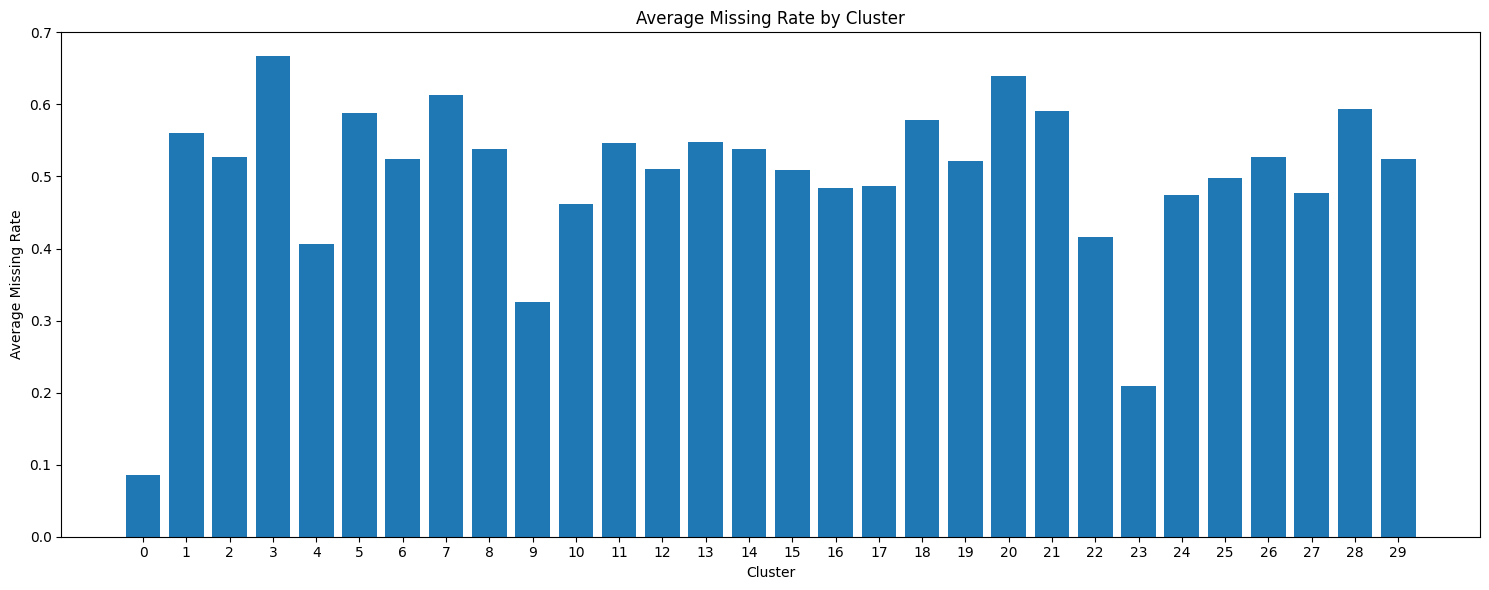

In [101]:
plt.figure(figsize=(15, 6))
plt.bar(cluster_summary.index.astype(str), cluster_summary.values)
plt.xlabel("Cluster")
plt.ylabel("Average Missing Rate")
plt.title("Average Missing Rate by Cluster")
plt.tight_layout()
plt.show()

In [102]:
del df_copy, df_merged

## **Handling Missing Data**

#### **Adding Missing Rows with NaNs**

In [103]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

def reindex_group(group):
    group = group.set_index('seconds_in_bucket').sort_index()
    complete_index = range(600)
    group = group.reindex(complete_index)
    group['time_id'] = group['time_id'].ffill().astype(int)
    result = group.reset_index().rename(columns={'index': 'seconds_in_bucket'})
    result = result[['time_id', 'seconds_in_bucket'] + [col for col in result.columns 
                                                        if col not in ('time_id', 'seconds_in_bucket')]]
    return result

df_complete = stock1.groupby('time_id', group_keys=False).apply(reindex_group).reset_index(drop=True)
df_complete

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,1,0,1.000754,1.001542,1.000689,1.001607,1.0,25.0,25.0,100.0
1,1,1,1.000754,1.001673,1.000689,1.001739,26.0,60.0,25.0,100.0
2,1,2,1.000754,1.001411,1.000623,1.001476,1.0,25.0,25.0,125.0
3,1,3,1.000754,1.001542,1.000689,1.001607,125.0,25.0,126.0,36.0
4,1,4,1.000754,1.001476,1.000623,1.001542,100.0,100.0,25.0,25.0
...,...,...,...,...,...,...,...,...,...,...
2297995,3830,595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297996,3830,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297997,3830,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297998,3830,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
counts = df_complete.groupby('time_id')['seconds_in_bucket'].count()
print(counts.unique())

[600]


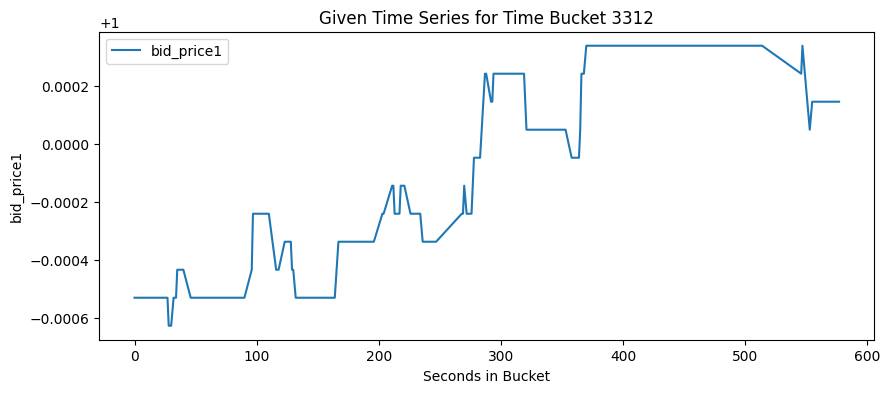

In [105]:
bucket_id = stock1['time_id'].unique()[3311]
bucket_data = stock1[stock1['time_id'] == bucket_id]

plt.figure(figsize=(10, 4))
plt.plot(bucket_data['seconds_in_bucket'], bucket_data['ask_price1'], label='bid_price1')
plt.xlabel('Seconds in Bucket')
plt.ylabel('bid_price1')
plt.title(f'Given Time Series for Time Bucket {bucket_id}')
plt.legend()
plt.show()

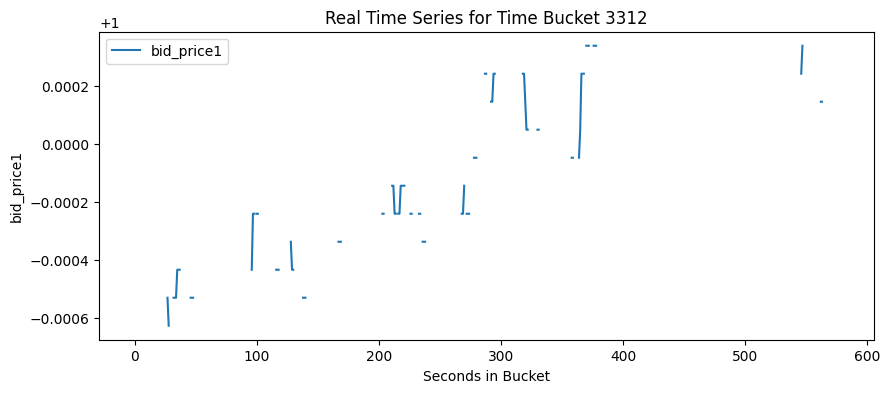

In [106]:
bucket_id = df_complete['time_id'].unique()[3311]
bucket_data = df_complete[df_complete['time_id'] == bucket_id]

plt.figure(figsize=(10, 4))
plt.plot(bucket_data['seconds_in_bucket'], bucket_data['ask_price1'], label='bid_price1')
plt.xlabel('Seconds in Bucket')
plt.ylabel('bid_price1')
plt.title(f'Real Time Series for Time Bucket {bucket_id}')
plt.legend()
plt.show()

#### **Removing High Missing Time_IDs and Imputing Low Missing Time_IDs**

In [107]:
def remove_timeIDs(percent: float = 0.7):

    seconds_per_time_id = stock1.groupby("time_id")["seconds_in_bucket"].nunique()
    expected_seconds = 600
    missing_seconds = expected_seconds - seconds_per_time_id
    high_missing_threshold = percent * expected_seconds 

    rem_time_ids = missing_seconds[missing_seconds > high_missing_threshold].index
    df_processed = df_complete[~df_complete["time_id"].isin(rem_time_ids)].copy() 
    df_processed['time_id'] = pd.factorize(df_processed['time_id'])[0] + 1
    
    return df_processed

df_processed = remove_timeIDs()
df_processed

# Is removing Time_IDs okay? How would this affect model accuracy? Is Re-labelling okay or shall I leave the lables?

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,1,0,1.000754,1.001542,1.000689,1.001607,1.0,25.0,25.0,100.0
1,1,1,1.000754,1.001673,1.000689,1.001739,26.0,60.0,25.0,100.0
2,1,2,1.000754,1.001411,1.000623,1.001476,1.0,25.0,25.0,125.0
3,1,3,1.000754,1.001542,1.000689,1.001607,125.0,25.0,126.0,36.0
4,1,4,1.000754,1.001476,1.000623,1.001542,100.0,100.0,25.0,25.0
...,...,...,...,...,...,...,...,...,...,...
2297995,3778,595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297996,3778,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297997,3778,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2297998,3778,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
def impute_timeIDs(df, percent: float = 0.3):

    groups = []
    expected_seconds = 600
    allowed_missing = percent * expected_seconds 

    for time_id, group in df.groupby("time_id"):
        unique_secs = group["seconds_in_bucket"].nunique()
        missing_count = expected_seconds - unique_secs
        
        if missing_count <= allowed_missing:

            full_index = range(expected_seconds)
            group_temp = group.set_index("seconds_in_bucket")
            group_temp = group_temp.reindex(full_index)
            
            group_temp["time_id"] = time_id
            group_temp["seconds_in_bucket"] = group_temp.index
            
            numeric_cols = group_temp.select_dtypes(include=["number"]).columns
            group_temp[numeric_cols] = group_temp[numeric_cols].interpolate(method="linear")
            
            group_temp = group_temp.ffill().bfill()
            groups.append(group_temp.reset_index(drop=True))
        else:
            groups.append(group)
    
    return pd.concat(groups, ignore_index=True)

df_processed_imputed = impute_timeIDs(df_processed)
df_complete_imputed = impute_timeIDs(df_complete)

## **Feature Engineering**

#### **Reading CSV**

In [8]:
stock1 = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_1.csv")
if stock1["stock_id"].nunique() == 1:
    stock1 = stock1.drop(columns="stock_id", errors="ignore")
    stock1['time_id'] = pd.factorize(stock1['time_id'])[0] + 1
stock1

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,1,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100
1,1,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100
2,1,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125
3,1,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36
4,1,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25
...,...,...,...,...,...,...,...,...,...,...
1507527,3830,588,0.998911,0.999109,0.998812,0.999208,126,42,101,100
1507528,3830,589,0.998911,0.999109,0.998812,0.999208,126,126,101,200
1507529,3830,591,0.998911,0.999109,0.998812,0.999208,126,226,101,200
1507530,3830,592,0.998911,0.999109,0.998812,0.999208,226,225,101,100


#### **Invalid Data Cleaning**

In [11]:
def pre_clean(df_clean: pd.DataFrame) -> pd.DataFrame:
    """
    Remove corrupt or out‑of‑range LOB records:
      1. Non‑positive prices and sizes
      2. Crossed quotes (ask < bid) at both levels
      3. seconds_in_bucket outside [0, 599]
      4. Duplicate or non‑monotonic timestamps within each time_id
    """

    price_cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']
    size_cols  = ['bid_size1',  'ask_size1',  'bid_size2',  'ask_size2']
    df_clean = df_clean[(df_clean[price_cols] > 0).all(axis=1)]
    df_clean = df_clean[(df_clean[size_cols]  > 0).all(axis=1)]

    df_clean = df_clean[
        (df_clean['ask_price1'] >= df_clean['bid_price1']) &
        (df_clean['ask_price2'] >= df_clean['bid_price2'])
    ]

    df_clean = df_clean[
        df_clean['seconds_in_bucket'].between(0, 599, inclusive="both")
    ]

    def _filter_time(group):
        group = group.drop_duplicates(subset='seconds_in_bucket')
        diffs = group['seconds_in_bucket'].diff().fillna(0)
        return group.loc[diffs >= 0]

    df_clean = (
        df_clean
        .sort_values(['time_id', 'seconds_in_bucket'])
        .groupby('time_id', group_keys=False)
        .apply(_filter_time)
        .reset_index(drop=True)
    )

    return df_clean

In [12]:
stock1 = pre_clean(stock1)
stock1

/var/folders/0s/bt69j7tj0pd5rl5dzr4n6bth0000gn/T/ipykernel_2308/31826074.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_filter_time)


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,1,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100
1,1,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100
2,1,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125
3,1,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36
4,1,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25
...,...,...,...,...,...,...,...,...,...,...
1507527,3830,588,0.998911,0.999109,0.998812,0.999208,126,42,101,100
1507528,3830,589,0.998911,0.999109,0.998812,0.999208,126,126,101,200
1507529,3830,591,0.998911,0.999109,0.998812,0.999208,126,226,101,200
1507530,3830,592,0.998911,0.999109,0.998812,0.999208,226,225,101,100


#### **Train-Test Split**

In [13]:
def time_series_train_test_split(
        df: pd.DataFrame, 
        time_id_col: str = 'time_id', 
        train_frac: float = 0.7, 
        sort_ids: bool = True, 
        random_state: int = None 
) -> Tuple[pd.DataFrame, pd.DataFrame, List[int], List[int]]:

    unique_ids = df[time_id_col].unique().tolist()
    
    if sort_ids:
        unique_ids.sort()
    else:
        rng = np.random.RandomState(random_state)
        rng.shuffle(unique_ids)

    split_at = int(len(unique_ids) * train_frac)
    train_ids = unique_ids[:split_at]
    test_ids  = unique_ids[split_at:]

    train_df = df[df[time_id_col].isin(train_ids)].reset_index(drop=True)
    test_df  = df[df[time_id_col].isin(test_ids)].reset_index(drop=True)

    return train_df, test_df, train_ids, test_ids

train_df, test_df, train_ids, test_ids = time_series_train_test_split(stock1, train_frac=0.7)

In [14]:
train_df

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,1,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100
1,1,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100
2,1,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125
3,1,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36
4,1,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25
...,...,...,...,...,...,...,...,...,...,...
1052789,2681,595,0.999575,1.000142,0.999292,1.000425,126,125,94,201
1052790,2681,596,0.999953,1.000330,0.999858,1.000425,100,97,200,1
1052791,2681,597,0.999953,1.000614,0.999764,1.000802,100,100,100,100
1052792,2681,598,1.000142,1.000614,0.999953,1.000991,1,100,100,248


In [15]:
test_df

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,2682,0,1.002703,1.003244,1.002595,1.003352,2,100,210,100
1,2682,1,1.002703,1.003244,1.002595,1.003352,2,100,210,161
2,2682,2,1.002811,1.003460,1.002703,1.003568,100,100,102,100
3,2682,3,1.002811,1.003460,1.002703,1.003568,200,100,2,100
4,2682,4,1.002811,1.003460,1.002703,1.003568,200,100,3,100
...,...,...,...,...,...,...,...,...,...,...
454733,3830,588,0.998911,0.999109,0.998812,0.999208,126,42,101,100
454734,3830,589,0.998911,0.999109,0.998812,0.999208,126,126,101,200
454735,3830,591,0.998911,0.999109,0.998812,0.999208,126,226,101,200
454736,3830,592,0.998911,0.999109,0.998812,0.999208,226,225,101,100


#### **Aggregate Features**

In [22]:
def compute_lob_features(
    df: pd.DataFrame,
    delta_list: List[int] = [1, 2, 5, 10],
    ema_spans: List[int] = [10, 30, 60, 120],
    time_id_col: str = 'time_id',
    sec_col: str = 'seconds_in_bucket'
) -> Dict[int, pd.DataFrame]:

    out: Dict[int, pd.DataFrame] = {}
    df_sorted = df.sort_values([time_id_col, sec_col])

    base_feats = ['mid_price', 'spread', 'rel_spread', 'imbalance', 'log_return']

    for delta_t in delta_list:
        # copy and bin
        tmp = df_sorted.copy()
        tmp['bin_end'] = (tmp[sec_col] // delta_t + 1) * delta_t

        # last tick per bin
        last = (
            tmp
            .groupby([time_id_col, 'bin_end'], as_index=False)
            .last()
        )

        # base features
        last['mid_price'] = (last['bid_price1'] + last['ask_price1']) / 2
        last['spread']    = last['ask_price1'] - last['bid_price1']
        last['rel_spread']= last['spread'] / last['mid_price']
        last['imbalance'] = (
            last['bid_size1'] - last['ask_size1']
        ) / (
            last['bid_size1'] + last['ask_size1']
        )
        last['book_pressure'] = (
            (last['bid_size1'] + last['bid_size2'])
            - (last['ask_size1'] + last['ask_size2'])
        ) / (
            last['bid_size1'] + last['bid_size2']
            + last['ask_size1'] + last['ask_size2']
        )

        # log returns per time_id, preserving alignment
        last['log_return'] = (
            last.groupby(time_id_col)['mid_price']
                .transform(lambda x: np.log(x / x.shift(1)))
        )

        # 3a) compute rv_future: 
        def _add_future_rv(group):
            # squared returns
            sq = group['log_return'].pow(2).values
            # cumulative sum backwards: total future variance at each index
            cum_rev = sq[::-1].cumsum()[::-1]
            # subtract current bin’s variance to get sum over (t+1 → end)
            future_var = cum_rev - sq
            group['rv_future'] = np.sqrt(future_var)
            return group

        last = last.groupby(time_id_col, group_keys=False).apply(_add_future_rv)

        # 3b) drop the last bin of each window (rv_future = 0)
        last = last[last['rv_future'] > 0].reset_index(drop=True)

        # EMAs for each span
        for feat in base_feats:
            for span in ema_spans:
                col = f"{feat}_ema_{span}s"
                last[col] = (
                    last.groupby(time_id_col)[feat]
                        .transform(lambda x: x.ewm(span=span, adjust=False).mean())
                )

        # select columns
        base_cols = [time_id_col, sec_col, 'mid_price', 'log_return',
                     'spread', 'rel_spread', 'imbalance', 'book_pressure',
                     'rv_future']
        ema_cols = [f"{feat}_ema_{span}s" for feat in base_feats for span in ema_spans]
        cols = base_cols + ema_cols

        out[delta_t] = last[cols].reset_index(drop=True)

    return out


feats_train = compute_lob_features(train_df, delta_list=[1,5,10,20,30,50], ema_spans=[10, 30, 60, 120])


/var/folders/0s/bt69j7tj0pd5rl5dzr4n6bth0000gn/T/ipykernel_2308/1592045183.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last = last.groupby(time_id_col, group_keys=False).apply(_add_future_rv)
/var/folders/0s/bt69j7tj0pd5rl5dzr4n6bth0000gn/T/ipykernel_2308/1592045183.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last = last.groupby(time_id_col, group_keys=False).apply(_add_future_rv)
/var/fol

In [23]:
train_df_feats = feats_train[1].dropna()

In [24]:
train_df_feats

,time_id,seconds_in_bucket,mid_price,log_return,spread,rel_spread,imbalance,book_pressure,rv_future,mid_price_ema_10s,...,rel_spread_ema_60s,rel_spread_ema_120s,imbalance_ema_10s,imbalance_ema_30s,imbalance_ema_60s,imbalance_ema_120s,log_return_ema_10s,log_return_ema_30s,log_return_ema_60s,log_return_ema_120s
0,1,1,1.001214,0.000066,0.000919,0.000917,-0.395349,-0.516588,0.003175,1.001214,...,0.000917,0.000917,-0.395349,-0.395349,-0.395349,-0.395349,0.000066,0.000066,6.552262e-05,0.000066
1,1,2,1.001083,-0.000131,0.000656,0.000655,-0.923077,-0.704545,0.003172,1.001190,...,0.000909,0.000913,-0.491299,-0.429396,-0.412651,-0.404072,0.000030,0.000053,5.907599e-05,0.000062
2,1,3,1.001148,0.000066,0.000787,0.000786,0.666667,0.608974,0.003172,1.001182,...,0.000905,0.000911,-0.280760,-0.358682,-0.377264,-0.386373,0.000036,0.000054,5.928913e-05,0.000062
3,1,4,1.001115,-0.000033,0.000722,0.000721,0.000000,0.000000,0.003171,1.001170,...,0.000899,0.000908,-0.229713,-0.335541,-0.364895,-0.379987,0.000024,0.000048,5.627103e-05,0.000061
4,1,5,1.001148,0.000033,0.000787,0.000786,0.600000,0.190476,0.003171,1.001166,...,0.000895,0.000906,-0.078856,-0.275184,-0.333259,-0.363789,0.000025,0.000047,5.550028e-05,0.000060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043256,2681,594,0.999858,0.000000,0.000566,0.000566,0.003984,0.284091,0.000406,0.999827,...,0.000601,0.000607,-0.053197,-0.087969,-0.124535,-0.104953,0.000007,-0.000011,-1.614130e-05,-0.000012
1043257,2681,595,0.999858,0.000000,0.000566,0.000566,0.003984,-0.194139,0.000406,0.999833,...,0.000600,0.000607,-0.042800,-0.082037,-0.120321,-0.103153,0.000006,-0.000010,-1.561208e-05,-0.000011
1043258,2681,596,1.000142,0.000283,0.000378,0.000378,0.015228,0.507538,0.000291,0.999889,...,0.000592,0.000603,-0.032250,-0.075762,-0.115877,-0.101196,0.000056,0.000009,-5.814960e-06,-0.000007
1043259,2681,597,1.000283,0.000142,0.000661,0.000661,0.000000,0.000000,0.000254,0.999960,...,0.000595,0.000604,-0.026386,-0.070874,-0.112078,-0.099523,0.000072,0.000018,-9.826685e-07,-0.000004


#### **Winzorize**

In [26]:
def winsorize_df(df, lower_quantile=0.02, upper_quantile=0.98, exclude_cols=None):

    if exclude_cols is None:
        exclude_cols = ['time_id', 'seconds_in_bucket']
    
    cols_to_winsorize = [col for col in df.columns 
                         if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]
    
    quantiles = df[cols_to_winsorize].quantile([lower_quantile, upper_quantile])
    lower_bounds = quantiles.loc[lower_quantile]
    upper_bounds = quantiles.loc[upper_quantile]
    
    clipped = df[cols_to_winsorize].clip(lower=lower_bounds, upper=upper_bounds, axis=1)
    result = df.copy()
    result[cols_to_winsorize] = clipped
    
    return result

train_df_feats_winz = winsorize_df(train_df_feats)


In [27]:
train_df_feats_winz

,time_id,seconds_in_bucket,mid_price,log_return,spread,rel_spread,imbalance,book_pressure,rv_future,mid_price_ema_10s,...,rel_spread_ema_60s,rel_spread_ema_120s,imbalance_ema_10s,imbalance_ema_30s,imbalance_ema_60s,imbalance_ema_120s,log_return_ema_10s,log_return_ema_30s,log_return_ema_60s,log_return_ema_120s
0,1,1,1.001214,0.000066,0.000919,0.000917,-0.395349,-0.516588,0.003175,1.001214,...,0.000917,0.000917,-0.395349,-0.395349,-0.395349,-0.395349,0.000066,0.000066,6.552262e-05,0.000066
1,1,2,1.001083,-0.000131,0.000656,0.000655,-0.923077,-0.704545,0.003172,1.001190,...,0.000909,0.000913,-0.491299,-0.429396,-0.412651,-0.404072,0.000030,0.000053,5.907599e-05,0.000062
2,1,3,1.001148,0.000066,0.000787,0.000786,0.666667,0.608974,0.003172,1.001182,...,0.000905,0.000911,-0.280760,-0.358682,-0.377264,-0.386373,0.000036,0.000054,5.928913e-05,0.000062
3,1,4,1.001115,-0.000033,0.000722,0.000721,0.000000,0.000000,0.003171,1.001170,...,0.000899,0.000908,-0.229713,-0.335541,-0.364895,-0.379987,0.000024,0.000048,5.627103e-05,0.000061
4,1,5,1.001148,0.000033,0.000787,0.000786,0.600000,0.190476,0.003171,1.001166,...,0.000895,0.000906,-0.078856,-0.275184,-0.333259,-0.363789,0.000025,0.000047,5.550028e-05,0.000060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043256,2681,594,0.999858,0.000000,0.000566,0.000566,0.003984,0.284091,0.000406,0.999827,...,0.000601,0.000607,-0.053197,-0.087969,-0.124535,-0.104953,0.000007,-0.000011,-1.614130e-05,-0.000012
1043257,2681,595,0.999858,0.000000,0.000566,0.000566,0.003984,-0.194139,0.000406,0.999833,...,0.000600,0.000607,-0.042800,-0.082037,-0.120321,-0.103153,0.000006,-0.000010,-1.561208e-05,-0.000011
1043258,2681,596,1.000142,0.000283,0.000378,0.000378,0.015228,0.507538,0.000291,0.999889,...,0.000592,0.000603,-0.032250,-0.075762,-0.115877,-0.101196,0.000056,0.000009,-5.814960e-06,-0.000007
1043259,2681,597,1.000283,0.000142,0.000661,0.000661,0.000000,0.000000,0.000254,0.999960,...,0.000595,0.000604,-0.026386,-0.070874,-0.112078,-0.099523,0.000072,0.000018,-9.826685e-07,-0.000004


#### **Feature Selection**

In [28]:
def select_features_next_window(
    df: pd.DataFrame,
    feature_cols: list[str] | None = None,
    target_col: str = "rv_future",
    corr_threshold: float = 0.10,
    mi_percentile: float = 75.0,
    random_state: int = None
) -> tuple[list[str], pd.DataFrame]:
    # 1) Drop any rows where target is missing
    df2 = df.dropna(subset=[target_col]).copy()

    # 2) Determine which columns are your features
    if feature_cols is None:
        feature_cols = [c for c in df2.columns if c != target_col]

    X = df2[feature_cols]
    y = df2[target_col]

    # 3) Pearson correlations
    pearson_corr = X.corrwith(y).abs()

    # 4) Mutual information
    mi_scores = pd.Series(
        mutual_info_regression(X, y, random_state=random_state),
        index=feature_cols
    )

    # 5) Threshold on MI
    mi_thresh = np.percentile(mi_scores, mi_percentile)

    # 6) Select by either criterion
    sel_by_corr = set(pearson_corr[pearson_corr >= corr_threshold].index)
    sel_by_mi   = set(mi_scores[mi_scores >= mi_thresh].index)
    selected    = sorted(sel_by_corr.union(sel_by_mi))

    # 7) Pack scores for inspection
    scores = pd.DataFrame({
        "pearson_corr": pearson_corr,
        "mutual_info":  mi_scores
    })

    return selected, scores

np.random.seed(3888)
selected_features, feature_scores = select_features_next_window(
    train_df_feats_winz,
    corr_threshold=0.10,
    mi_percentile=75.0,
    random_state=3888
)

In [29]:
print(feature_scores.loc[selected_features])

                     pearson_corr  mutual_info
imbalance                0.010160     0.877593
mid_price                0.020726     4.032183
mid_price_ema_120s       0.027362     0.576048
rel_spread               0.543314     4.133798
rel_spread_ema_10s       0.583167     0.301370
rel_spread_ema_120s      0.607015     0.495659
rel_spread_ema_30s       0.599743     0.340843
rel_spread_ema_60s       0.606468     0.395879
seconds_in_bucket        0.483133     0.290765
spread                   0.543350     3.525310
spread_ema_10s           0.583195     0.301290
spread_ema_120s          0.607043     0.496398
spread_ema_30s           0.599749     0.340637
spread_ema_60s           0.606492     0.395310
time_id                  0.000265     3.592327


In [50]:
if "seconds_in_bucket" not in selected_features:
    selected_features.append("seconds_in_bucket")

In [52]:
train_df_fws = train_df_feats_winz[selected_features]

In [53]:
train_df_fws

,imbalance,mid_price,mid_price_ema_120s,rel_spread,rel_spread_ema_10s,rel_spread_ema_120s,rel_spread_ema_30s,rel_spread_ema_60s,seconds_in_bucket,spread,spread_ema_10s,spread_ema_120s,spread_ema_30s,spread_ema_60s,time_id
0,-0.395349,1.001214,1.001214,0.000917,0.000917,0.000917,0.000917,0.000917,1,0.000919,0.000919,0.000919,0.000919,0.000919,1
1,-0.923077,1.001083,1.001212,0.000655,0.000870,0.000913,0.000901,0.000909,2,0.000656,0.000871,0.000914,0.000902,0.000910,1
2,0.666667,1.001148,1.001211,0.000786,0.000855,0.000911,0.000893,0.000905,3,0.000787,0.000856,0.000912,0.000894,0.000906,1
3,0.000000,1.001115,1.001209,0.000721,0.000830,0.000908,0.000882,0.000899,4,0.000722,0.000831,0.000909,0.000883,0.000900,1
4,0.600000,1.001148,1.001208,0.000786,0.000822,0.000906,0.000876,0.000895,5,0.000787,0.000823,0.000907,0.000877,0.000896,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043256,0.003984,0.999858,1.000554,0.000566,0.000601,0.000607,0.000606,0.000601,594,0.000566,0.000601,0.000608,0.000606,0.000601,2681
1043257,0.003984,0.999858,1.000542,0.000566,0.000595,0.000607,0.000604,0.000600,595,0.000566,0.000595,0.000607,0.000604,0.000600,2681
1043258,0.015228,1.000142,1.000535,0.000378,0.000555,0.000603,0.000589,0.000592,596,0.000378,0.000555,0.000603,0.000589,0.000593,2681
1043259,0.000000,1.000283,1.000531,0.000661,0.000574,0.000604,0.000594,0.000595,597,0.000661,0.000574,0.000604,0.000594,0.000595,2681


#### **Z-Scaling**

In [54]:
exclude_cols = ['time_id', 'seconds_in_bucket']
cols_to_scale = [col for col in train_df_fws.columns if col not in exclude_cols]

scaler = StandardScaler()
train_df_final = train_df_fws.copy()
train_df_final[cols_to_scale] = scaler.fit_transform(train_df_fws[cols_to_scale])

In [55]:
train_df_final

,imbalance,mid_price,mid_price_ema_120s,rel_spread,rel_spread_ema_10s,rel_spread_ema_120s,rel_spread_ema_30s,rel_spread_ema_60s,seconds_in_bucket,spread,spread_ema_10s,spread_ema_120s,spread_ema_30s,spread_ema_60s,time_id
0,-0.682212,0.355916,0.397308,0.508121,0.528852,0.476493,0.526648,0.512071,1,0.510432,0.531176,0.478705,0.529378,0.514729,1
1,-1.621174,0.318269,0.396612,-0.052169,0.421486,0.467048,0.488145,0.492679,2,-0.050657,0.423674,0.469248,0.490809,0.495305,1
2,1.207383,0.337100,0.396275,0.228101,0.387348,0.462484,0.471387,0.483623,3,0.229994,0.389489,0.464678,0.474020,0.486233,1
3,0.021214,0.327692,0.395770,0.088078,0.332585,0.455635,0.446087,0.470018,4,0.089776,0.334654,0.457820,0.448676,0.472605,1
4,1.088766,0.337100,0.395447,0.228101,0.314611,0.451259,0.432042,0.461705,5,0.229994,0.316655,0.453439,0.434605,0.464277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043256,0.028303,-0.032859,0.185258,-0.242235,-0.184508,-0.200013,-0.181786,-0.202503,594,-0.242389,-0.184737,-0.199310,-0.181718,-0.202006,2681
1043257,0.028303,-0.032859,0.181568,-0.242235,-0.198594,-0.201480,-0.187644,-0.205045,595,-0.242389,-0.198808,-0.200791,-0.187590,-0.204568,2681
1043258,0.048309,0.048372,0.179442,-0.646123,-0.287514,-0.209732,-0.220879,-0.221483,596,-0.645945,-0.287640,-0.209049,-0.220823,-0.221018,2681
1043259,0.021214,0.088988,0.178103,-0.041004,-0.244310,-0.207646,-0.210387,-0.216437,597,-0.040611,-0.244342,-0.206968,-0.210302,-0.215972,2681


array([[<Axes: title={'center': 'imbalance'}>,
        <Axes: title={'center': 'mid_price'}>,
        <Axes: title={'center': 'mid_price_ema_120s'}>,
        <Axes: title={'center': 'rel_spread'}>],
       [<Axes: title={'center': 'rel_spread_ema_10s'}>,
        <Axes: title={'center': 'rel_spread_ema_120s'}>,
        <Axes: title={'center': 'rel_spread_ema_30s'}>,
        <Axes: title={'center': 'rel_spread_ema_60s'}>],
       [<Axes: title={'center': 'seconds_in_bucket'}>,
        <Axes: title={'center': 'spread'}>,
        <Axes: title={'center': 'spread_ema_10s'}>,
        <Axes: title={'center': 'spread_ema_120s'}>],
       [<Axes: title={'center': 'spread_ema_30s'}>,
        <Axes: title={'center': 'spread_ema_60s'}>,
        <Axes: title={'center': 'time_id'}>, <Axes: >]], dtype=object)

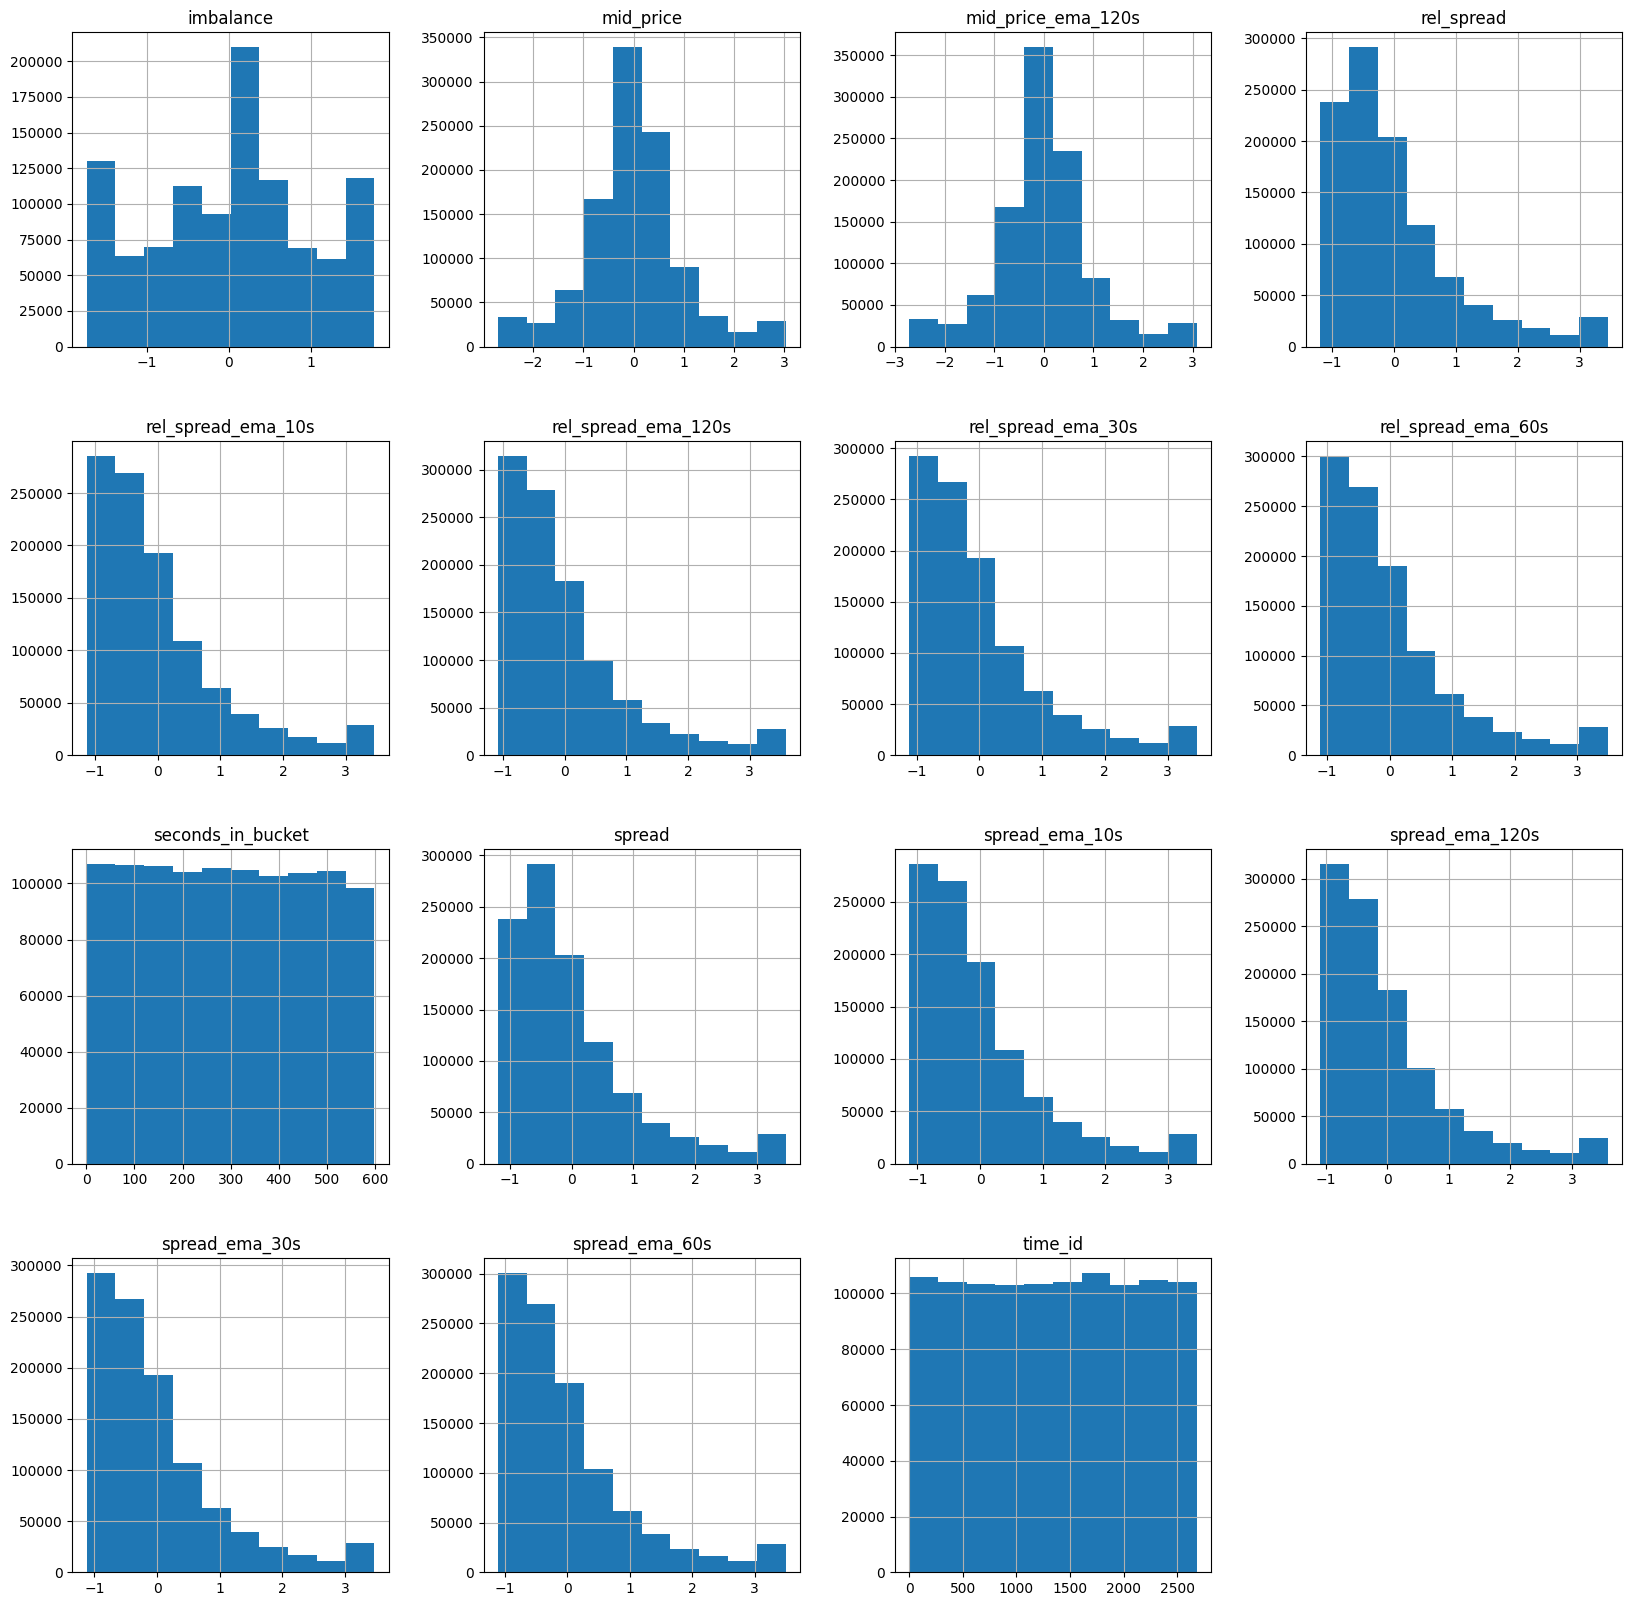

In [56]:
train_df_final.hist(figsize=(20,20))